# Distributed DataFrames and Efficiency

In the previous notebooks we discussed `dask.dataframe` and `dask.distributed`. Here we combine them on a different dataset while moving from local to distributed computing, and discuss efficiency and performance tips. 

We will cover the following topics:

1. Persist common intermediate results in memory with `persist`
2. Partitions and partition size
3. Using indices to improve efficiency
---

- Authors: NCI Virtual Research Environment Team
- Keywords: Dask, DataFrames, Distributed, Performance
- Creation Date: 2020-Sep
- Lineage/Reference: This tutorial is referenced to [dask tutorial](https://github.com/dask/dask-tutorial).
-----

## Environment setup

Choose the appropriate one from the following two senarios (1) local or VDI (2) Pangeo on Gadi:

In [1]:
# local or VDI
from dask.distributed import Client
client = Client()
print(client)

<Client: 'tcp://127.0.0.1:43043' processes=4 threads=4, memory=12.06 GB>


In [2]:
# Pangeo on Gadi
from dask.distributed import Client, LocalCluster
client = Client(scheduler_file='scheduler.json')
print(client)

<Client: 'tcp://10.6.76.35:8729' processes=96 threads=96, memory=322.12 GB>


<div class="alert alert-info">
<b>Warning: Please make sure you specify the correct path to the scheduler.json file within your environment.</b>  
</div>

Starting the Dask Client will provide a dashboard which is useful to gain insight into the computation. The link to the dashboard will become visible when you create the Client. We recommend having the Client open on one side of your screen and your notebook open on the other side, which will be useful for learning purposes.

Notes on distributed computing:

1. Environment: Each worker is a separate machine, and needs to have the required libraries installed. HPCs provide tools to help manage this.

2. File system: In the local mode, every worker (threads, processes, or even the distributed scheduler) had access to your laptop's filesystem. In a distributed environment, you'll need some kind of shared filesystem to read data (cloud storage or a global file system). Mostly we have already been using a global file system in these exercises.

3. Communication: Moving data between machines is relatively expensive. When possible, the distributed scheduler will ensure that tasks are scheduled to be run on workers that already have the required data. But some tasks will require data from multiple machines.


## The Geochemistry dataset

OZCHEM is Geoscience Australia's national whole-rock geochemical database. This release of OZCHEM contains over 50,000 analyses of rocks, regolith and stream sediments from many regions of Australia. Each analysis includes a geographic location and a geological description, which includes the host stratigraphic unit, where known, and the lithology. Most samples have been collected by Geoscience Australia's field parties. OZCHEM is stored in an ORACLE relational database and is available in comma-delimited flat ASCII format. The data set is also bundled with documentation explaining the database structure and includes definitions of the database tables and columns (attributes). It has been downloaded and stored in our `demo_data` directory. Please see details about this dataset in the [catalogue](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/65464).

The geochemistry dataset was downloaded from Geoscience Australia. The tweak that I did is to capitalise all the "Qld" in the state column in the QLD csv file. 

In [2]:
from glob import glob
filenames = sorted(glob('/g/data/dk92/notebooks/demo_data/Geochem/65464*/*.csv'))
filenames

['/g/data/dk92/notebooks/demo_data/Geochem/65464_act/Geochemistry_ACT_10_10_2007.csv',
 '/g/data/dk92/notebooks/demo_data/Geochem/65464_nsw/Geochemistry_NSW_11_10_2007.csv',
 '/g/data/dk92/notebooks/demo_data/Geochem/65464_nt/Geochemistry_NT_10_10_2007.csv',
 '/g/data/dk92/notebooks/demo_data/Geochem/65464_qld/Geochemistry_QLD_10_10_2007.csv',
 '/g/data/dk92/notebooks/demo_data/Geochem/65464_sa/Geochemistry_SA_10_10_2007.csv',
 '/g/data/dk92/notebooks/demo_data/Geochem/65464_tas/Geochemistry_TAS_11_10_2007.csv',
 '/g/data/dk92/notebooks/demo_data/Geochem/65464_vic/Geochemistry_VIC_11_10_2007.csv',
 '/g/data/dk92/notebooks/demo_data/Geochem/65464_wa/Geochemistry_WA_10_10_2007.csv',
 '/g/data/dk92/notebooks/demo_data/Geochem/65464_wa/Geochemistry_WA_10_10_20071.csv']

Read all the data into a single `dask.dataframe` object by stacking all csv files as partitions. Have a peek at the first five samples to get an idea what the properties of the samples were tested and recorded.

In [3]:
import dask.dataframe as dd

df = dd.read_csv('/g/data/dk92/notebooks/demo_data/Geochem/65464*/*.csv', dtype={'geogarea': 'object',
       'hmapno': 'float64',
       'utm_zone': 'float64',
       'Ba': 'float64',
       'Bi': 'float64',
       'Ce': 'float64',
       'Co': 'float64',
       'Cr': 'float64',
       'Cu': 'float64',
       'La': 'float64',
       'Mo': 'float64',
       'Nb': 'float64',
       'Ni': 'float64',
       'Pb': 'float64',
       'Rb': 'float64',
       'Sc': 'float64',
       'Sn': 'float64',
       'Sr': 'float64',
       'Ta': 'float64',
       'Th': 'float64',
       'U': 'float64',
       'V': 'float64',
       'W': 'float64',
       'Y': 'float64',
       'Zn': 'float64',
       'Zr': 'float64',
       'grouping': 'object',
       'sampleid': 'object',
       'siteid': 'object'}, encoding='latin1')

Note `latin1` will decode anything because it maps every byte to a Unicode code point. Ignoring this argument will result the WA data not being readable.

In [4]:
df.head()

,uid,eno,siteid,state,country,geogarea,locdesc,hmapno,qmapid,easting,...,Th,Ti,Tm,U,V,W,Y,Yb,Zn,Zr
0,1,105755,79620142,ACT,Australia,NaN,same location as 0143,8727.0,SI5516,688912.433,...,15.0,NaN,NaN,-3.0,95.0,6.0,34.0,NaN,51.0,184.0
1,2,105756,79620143,ACT,Australia,NaN,same location as 0142,8727.0,SI5516,688912.433,...,15.0,NaN,NaN,-3.0,35.0,-5.0,29.0,NaN,56.0,225.0
2,3,109421,79620862,ACT,Australia,NaN,NaN,8627.0,SI5516,678812.457,...,17.0,NaN,NaN,-3.0,49.0,-5.0,34.0,NaN,179.0,201.0
3,4,109422,79620863,ACT,Australia,NaN,NaN,8627.0,SI5516,663412.482,...,30.0,NaN,NaN,12.0,11.0,15.0,67.0,NaN,11.0,113.0
4,5,109424,79620864,ACT,Australia,NaN,NaN,8627.0,SI5516,674412.476,...,24.0,NaN,NaN,4.0,53.0,5.0,48.0,NaN,34.0,188.0


Let's see what are the 113 properties of the rock sample.

In [5]:
df.columns

Index(['uid', 'eno', 'siteid', 'state', 'country', 'geogarea', 'locdesc',
       'hmapno', 'qmapid', 'easting',
       ...
       'Th', 'Ti', 'Tm', 'U', 'V', 'W', 'Y', 'Yb', 'Zn', 'Zr'],
      dtype='object', length=113)

In [6]:
a = df.groupby('state').uid.count()
a.compute()

state
ACT      197
NSW     8697
NT     13165
QLD    21948
SA      2734
TAS     1189
VIC     1287
WA     35557
Name: uid, dtype: int64

Let's have a look at the sample distribution across Australia.

**Please note that the following cell requires a download of coastline, hence does not work within Pangeo environment on Gadi as it is restricted to compute nodes with no external access. However, this piece of code would work on local computer, VDI and Gadi login node; or should work using the `hh5` environment which has pre-downloaded map data.**

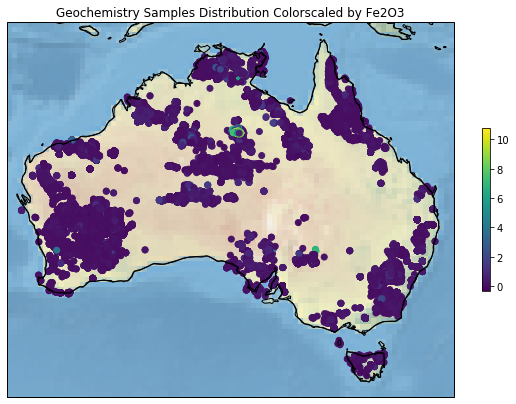

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.stock_img()
ax.add_feature(cf.COASTLINE)
extent = [112,155,-43,-9]
ax.set_extent(extent)
ax.coastlines(resolution='50m')
ax.set_title("Geochemistry Samples Distribution Colorscaled by Fe2O3")
splot = plt.scatter(df.longitude.compute(),df.latitude.compute(),c=0.1*df.Fe2O3.compute())
fig.colorbar(splot, shrink=0.3)
ax.set_xlabel('lat')
ax.set_ylabel('lon')
plt.show()

### Persist data in distributed memory

Every time we run an operation like `df.longitude.compute()` we read through our dataset from disk. This can be slow, especially because we're reading data from CSV. We usually have two options to make this faster:

1. Persist relevant data in memory, either on our computer or on a cluster
2. Use a faster on-disk format, like HDF5 or Parquet

In this section we persist our data in memory. On a single machine this is often done by doing a bit of pre-processing and data reduction with dask dataframe and then running `compute` to a Pandas dataframe and using Pandas in the future.  

```python
df = dd.read_csv(...)
df = df[df.Origin == 'LGA']  # filter down to smaller dataset
pdf = df.compute()  # convert to pandas
pdf ... # continue with familiar Pandas workflows
```

However on a distributed cluster when even our cleaned data is too large we still can't use Pandas. In this case we ask Dask to persist data in memory with the `dask.persist` function. This is what the next cell does. This will help us to understand when data is lazy and when it is computing.

You can trigger computations using the persist method:

    x = x.persist()

or the dask.persist function for multiple inputs:

    x, y = dask.persist(x, y)

### Let's compare before and after we persist the dataframe into memory.

In [7]:
%time _ = df.longitude.compute()

CPU times: user 84.2 ms, sys: 43.8 ms, total: 128 ms
Wall time: 343 ms


In [8]:
df = df.persist()

In [9]:
%time _ = df.longitude.compute()

CPU times: user 40.9 ms, sys: 401 µs, total: 41.3 ms
Wall time: 40.5 ms


Alternatively, look at the plots in the diagnostic dashboard, what is taking up most of the time? (You can hover over rectangles to see what function they represent)

## Partitions

One `dask.dataframe` is composed of several Pandas dataframes.  The organization of these dataframes can significantly impact performance.  In this section we discuss two common factors that commonly impact performance:

1. The number of Pandas dataframes can affect overhead.  If the dataframes are too small then Dask might spend more time deciding what to do than Pandas spends actually doing it.  Ideally computations should take 100's of milliseconds.

2. If we know how the dataframes are sorted then certain operations become much faster.

### Number of partitions and partition size

When we read in our data from CSV files we get potentially multiple Pandas dataframes for each file. Look at the metadata below to determine a few things about the current partitioning:
- How many partitions are there?
- Are the splits along the index between partitions known? If so, what are they?

In [10]:
# Number of partitions
df.npartitions

9

In [11]:
# Are the splits between partitions known?
df.known_divisions

False

In [12]:
# The splits between partitions. If unknown these are all `None`
df.divisions

(None, None, None, None, None, None, None, None, None, None)

### Sorted Index column

Many dataframe operations like loc-indexing, groupby-apply, and joins are *much* faster on a sorted index.  For example, if we want to get data for a particular day of data it *really* helps to know where that day is, otherwise we need to search over all of our data.

The Pandas model gives us a sorted index column. `Dask.dataframe` copies this model, and it remembers the min and max values of every partition's index.

By default, our data doesn't have an index.

In [13]:
df.head()

,uid,eno,siteid,state,country,geogarea,locdesc,hmapno,qmapid,easting,...,Th,Ti,Tm,U,V,W,Y,Yb,Zn,Zr
0,1,105755,79620142,ACT,Australia,NaN,same location as 0143,8727.0,SI5516,688912.433,...,15.0,NaN,NaN,-3.0,95.0,6.0,34.0,NaN,51.0,184.0
1,2,105756,79620143,ACT,Australia,NaN,same location as 0142,8727.0,SI5516,688912.433,...,15.0,NaN,NaN,-3.0,35.0,-5.0,29.0,NaN,56.0,225.0
2,3,109421,79620862,ACT,Australia,NaN,NaN,8627.0,SI5516,678812.457,...,17.0,NaN,NaN,-3.0,49.0,-5.0,34.0,NaN,179.0,201.0
3,4,109422,79620863,ACT,Australia,NaN,NaN,8627.0,SI5516,663412.482,...,30.0,NaN,NaN,12.0,11.0,15.0,67.0,NaN,11.0,113.0
4,5,109424,79620864,ACT,Australia,NaN,NaN,8627.0,SI5516,674412.476,...,24.0,NaN,NaN,4.0,53.0,5.0,48.0,NaN,34.0,188.0


So if we search for a particular sample it takes a while because it has to pass through all of the data.

In [14]:
%time df[df.sampleid == '68590046'].compute()

CPU times: user 43.7 ms, sys: 1.44 ms, total: 45.1 ms
Wall time: 61 ms


,uid,eno,siteid,state,country,geogarea,locdesc,hmapno,qmapid,easting,...,Th,Ti,Tm,U,V,W,Y,Yb,Zn,Zr
19,22073,85421,68590046,QLD,Australia,Coastal Ranges Igneous Province: Hodgkinson re...,"Simpson Point on Cook Highway, 11km N of Kuranda",8064.0,SE5502,355845.667,...,17.0,NaN,NaN,3.0,NaN,NaN,35.0,NaN,69.0,194.0


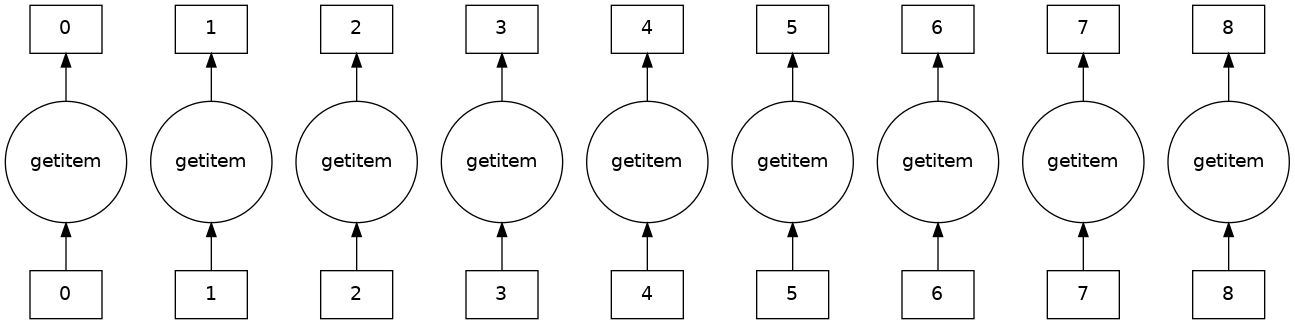

In [15]:
df[df.sampleid == '68590046'].visualize(optimize_graph=True)

However if we set the `sampleid` column as the index then this operation can be much faster.

Calling `set_index` followed by `persist` results in a new set of dataframe partitions stored in memory, sorted along the index column. To do this dask has to:

- Shuffle the data by sampleid, resulting in the same number of output partitions
- Set the index for each partition
- Store the resulting partitions in distributed memory

This can be a (relatively) expensive operation, but allows certain queries to be more optimized. 

Watch the diagnostics page while the next line is running to see how the shuffle and index operation progresses.

In [16]:
%%time
df = df.persist()

CPU times: user 24.5 ms, sys: 7.83 ms, total: 32.4 ms
Wall time: 31 ms


Repeating the same query for a specific sample, we can see that we're faster after setting the index:

In [17]:
df.columns

Index(['uid', 'eno', 'siteid', 'state', 'country', 'geogarea', 'locdesc',
       'hmapno', 'qmapid', 'easting',
       ...
       'Th', 'Ti', 'Tm', 'U', 'V', 'W', 'Y', 'Yb', 'Zn', 'Zr'],
      dtype='object', length=113)

In [18]:
%time df[df.sampleid == '68590046'].compute()

CPU times: user 44.3 ms, sys: 855 µs, total: 45.2 ms
Wall time: 59.5 ms


,uid,eno,siteid,state,country,geogarea,locdesc,hmapno,qmapid,easting,...,Th,Ti,Tm,U,V,W,Y,Yb,Zn,Zr
19,22073,85421,68590046,QLD,Australia,Coastal Ranges Igneous Province: Hodgkinson re...,"Simpson Point on Cook Highway, 11km N of Kuranda",8064.0,SE5502,355845.667,...,17.0,NaN,NaN,3.0,NaN,NaN,35.0,NaN,69.0,194.0


If you look at the resulting graph, you can see that dask was able to optimize the computation to only look at a single partition.

<div class="alert alert-warning">
<b>NOTE:</b> Another useful application of setting index for performance opertimisation is shuffling the data using the date as the index. </div>


In [19]:
# clean up, when finished with the notebook
client.close()